Earth Engine Python API.

In [7]:
%pip install -U geemap

Note: you may need to restart the kernel to use updated packages.


In [8]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()
# Authenticate and initialize Earth Engine
ee.Initialize()

In [9]:
# Define ROI
coordinates = [
    [42.000552219688586, 38.18969302118053],
    [43.868228000938586, 38.18969302118053],
    [43.868228000938586, 39.209978258633186],
    [42.000552219688586, 39.209978258633186],
    [42.000552219688586, 38.18969302118053]
]
roi = ee.Geometry.Polygon([coordinates])

# Time range
time_start = '2013-01-01'
time_end = '2021-12-31'

# Load and merge Landsat 7 & 8 SR collections
landsat7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
image_collection = landsat7.merge(landsat8) \
    .filterDate(time_start, time_end) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .filter(ee.Filter.calendarRange(6, 9, 'month')) \
    .filterBounds(roi)

# Compute NDWI
def compute_ndwi(img):
    scaled = img.select(['SR_B3', 'SR_B5']).multiply(2.75e-05).add(-0.2)
    ndwi = scaled.normalizedDifference(['SR_B3', 'SR_B5']).rename('ndwi')
    return ndwi.copyProperties(img, img.propertyNames())

ndwi_collection = image_collection.map(compute_ndwi)

# Median NDWI
ndwi_median = ndwi_collection.median()

# Thresholds and masks
ndwi_thr = ndwi_median.gt(0)
ndwi_mask = ndwi_median.gt(0.1).updateMask(ndwi_median.gt(0.1))

# Pixel area in km²
pixel_area = ndwi_mask.multiply(ee.Image.pixelArea().divide(1e6))

# Reduce to total lake area
lake_area = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13
).get('ndwi')

# Print result
print('Lake area (km²):', lake_area.getInfo())

# Visualization
Map = geemap.Map(center=[38.7, 42.9], zoom=8)
Map.addLayer(roi, {'color': 'red'}, 'ROI')
Map.addLayer(ndwi_median.clip(roi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Median')
Map.addLayer(ndwi_thr.clip(roi), {'palette': ['cyan']}, 'NDWI > 0')
Map.addLayer(ndwi_mask.clip(roi), {'palette': ['blue']}, 'NDWI > 0.1 Masked')
Map.addLayer(pixel_area.clip(roi), {'min': 0, 'max': 1, 'palette': ['yellow', 'green']}, 'Pixel Area (km²)')
Map


Lake area (km²): 3806.383715247839


Map(center=[38.7, 42.9], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

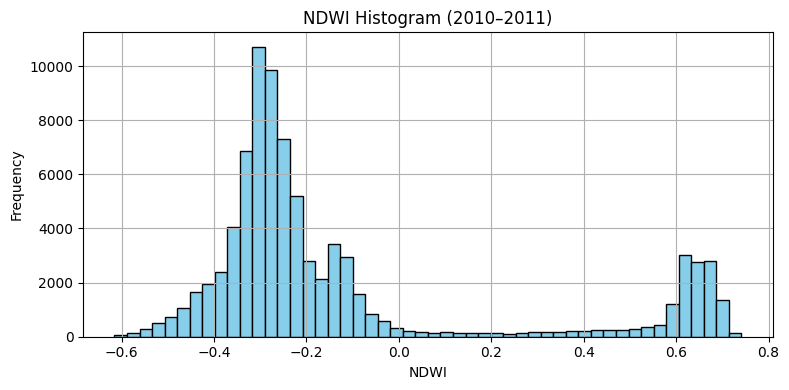

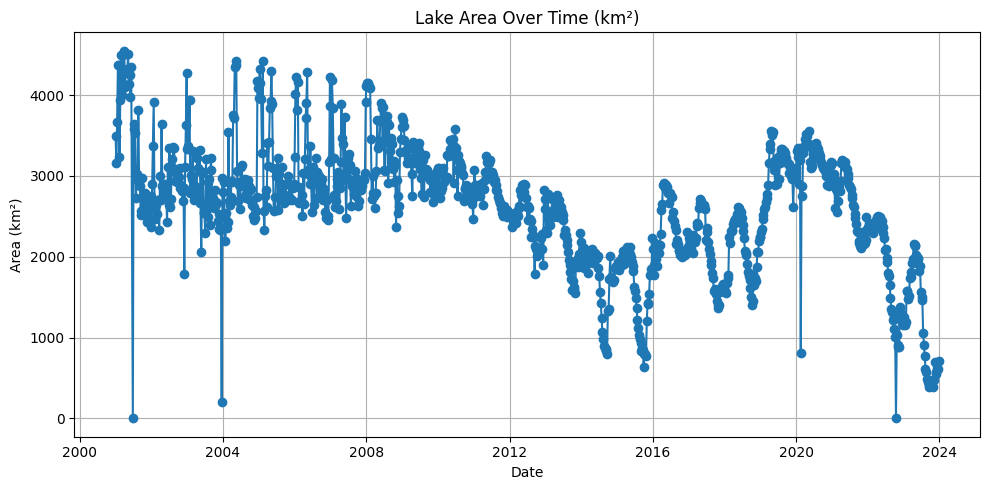

Map(center=[37.7, 45.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [10]:


# Define ROI
coordinates = [
    [44.82021271860131, 37.08040466447922],
    [46.11659943735131, 37.08040466447922],
    [46.11659943735131, 38.37506300104177],
    [44.82021271860131, 38.37506300104177],
    [44.82021271860131, 37.08040466447922]
]
roi = ee.Geometry.Polygon([coordinates])

# Time range
time_start = '2001-01-01'
time_end = '2023-12-31'

# Load MODIS MOD09A1 collection
modis = ee.ImageCollection("MODIS/061/MOD09A1").filterDate(time_start, time_end)

# Compute NDWI
def compute_ndwi(img):
    band = img.select(['sur_refl_b04', 'sur_refl_b02']).multiply(0.0001)
    ndwi = band.normalizedDifference(['sur_refl_b04', 'sur_refl_b02']).rename('ndwi')
    return ndwi.copyProperties(img, img.propertyNames())

ndwi_collection = modis.map(compute_ndwi)

# Visualize stacked NDWI bands for 2010–2011
ndwi_bands = ndwi_collection.filterDate('2010-01-01', '2011-12-31').toBands().clip(roi)

# Compute median NDWI for histogram
ndwi_median = ndwi_collection.filterDate('2010-01-01', '2011-12-31').median()

# Compute lake area time series
def compute_area(img):
    mask = img.gt(0.1).updateMask(img.gt(0.1))
    area = mask.multiply(ee.Image.pixelArea().divide(1e6))  # km²
    return area.copyProperties(img, img.propertyNames())

lake_area_series = ndwi_collection.map(compute_area)

# Extract lake area values for plotting
def extract_area(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=500,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
        'area': stats.get('ndwi')
    })

features = lake_area_series.map(extract_area).getInfo()['features']
data = pd.DataFrame([f['properties'] for f in features])
data['date'] = pd.to_datetime(data['date'])
data['area'] = pd.to_numeric(data['area'], errors='coerce')

# Plot histogram of NDWI median
ndwi_values = ndwi_median.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=500,
    maxPixels=1e13
).get('ndwi')

ndwi_list = ee.List(ndwi_values).getInfo()
plt.figure(figsize=(8, 4))
plt.hist(ndwi_list, bins=50, color='skyblue', edgecolor='black')
plt.title('NDWI Histogram (2010–2011)')
plt.xlabel('NDWI')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot lake area time series
plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['area'], marker='o', linestyle='-')
plt.title('Lake Area Over Time (km²)')
plt.xlabel('Date')
plt.ylabel('Area (km²)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Map visualization
Map = geemap.Map(center=[37.7, 45.5], zoom=7)
Map.addLayer(roi, {}, 'ROI')
Map.addLayer(ndwi_bands, {}, 'NDWI Bands (2010–2011)')
Map.addLayer(ndwi_median.clip(roi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Median')
Map


CHIRPS Precipitation Anomaly Analysis in Python

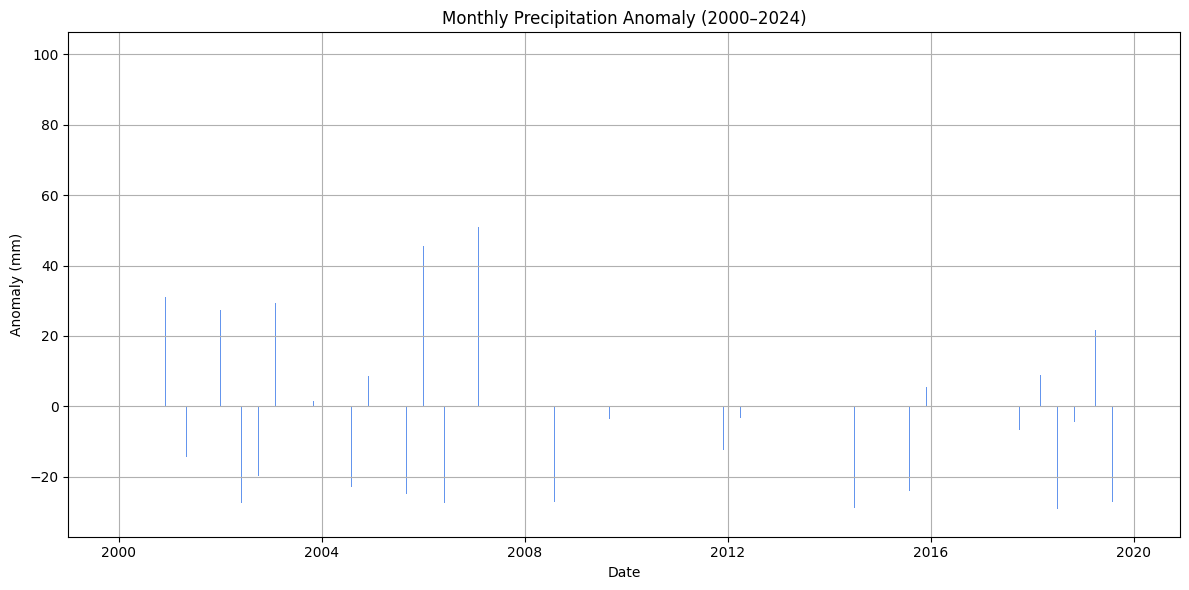

In [11]:

# Define ROI as MultiPolygon
coordinates = [[
    [54.04610024292115, 36.26824729036319],
    [56.30928383667115, 36.26824729036319],
    [56.30928383667115, 37.7942120428063],
    [54.04610024292115, 37.7942120428063],
    [54.04610024292115, 36.26824729036319]
]]
roi = ee.Geometry.MultiPolygon([coordinates])

# Time range
time_start = '2000-01-01'
time_end = '2024-12-31'

# Load CHIRPS daily precipitation
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(time_start, time_end)

# Temporal aggregation function (monthly sums)
def temporal_collection(collection, start, count, interval, unit):
    origin_date = ee.Date(start)
    sequence = ee.List.sequence(0, count - 1)
    
    def map_fn(i):
        i = ee.Number(i)
        start_date = origin_date.advance(i.multiply(interval), unit)
        end_date = origin_date.advance(i.add(1).multiply(interval), unit)
        summed = collection.filterDate(start_date, end_date).sum()
        return summed.set({
            'system:time_start': start_date.millis(),
            'system:time_end': end_date.millis()
        })
    
    return ee.ImageCollection(sequence.map(map_fn))

# Generate monthly precipitation collection
monthly = temporal_collection(chirps, time_start, 240, 1, 'month')

# Mean precipitation
pr_mean = monthly.mean()

# Compute anomaly
def compute_anomaly(img):
    anomaly = img.subtract(pr_mean)
    return anomaly.copyProperties(img, img.propertyNames())

anomaly_collection = monthly.map(compute_anomaly)

# Visualization map
Map = geemap.Map(center=[37.0, 55.2], zoom=6)
Map.addLayer(roi, {}, 'ROI')
Map.addLayer(pr_mean.clip(roi), {'min': 0, 'max': 300, 'palette': ['white', 'blue']}, 'Mean Precipitation')
Map.addLayer(anomaly_collection.filterDate('2010-01-01', '2024-12-31').toBands().clip(roi), {}, 'Anomaly 2010–2024')
Map

# Time series chart
def extract_mean(img):
    mean = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=5000,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
        'anomaly': mean.get('precipitation')
    })

# Rename band for consistency
anomaly_collection = anomaly_collection.map(lambda img: img.rename(['precipitation']))

features = anomaly_collection.map(extract_mean).getInfo()['features']
data = pd.DataFrame([f['properties'] for f in features])
data['date'] = pd.to_datetime(data['date'])
data['anomaly'] = pd.to_numeric(data['anomaly'], errors='coerce')

# Plot column chart
plt.figure(figsize=(12, 6))
plt.bar(data['date'], data['anomaly'], color='cornflowerblue')
plt.title('Monthly Precipitation Anomaly (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Anomaly (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()


🌧️ CHIRPS Precipitation Anomaly Analysis in Python

In [13]:
# Define ROI as MultiPolygon
coordinates = [[
    [54.04610024292115, 36.26824729036319],
    [56.30928383667115, 36.26824729036319],
    [56.30928383667115, 37.7942120428063],
    [54.04610024292115, 37.7942120428063],
    [54.04610024292115, 36.26824729036319]
]]
roi = ee.Geometry.MultiPolygon([coordinates])

# Time range
time_start = '2000-01-01'
today = datetime.utcnow().strftime('%Y-%m-%d')

# Load CHIRPS daily precipitation
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(time_start, today)

# Calculate number of months dynamically
start_dt = datetime.strptime(time_start, '%Y-%m-%d')
end_dt = datetime.utcnow()
month_count = (end_dt.year - start_dt.year) * 12 + end_dt.month - start_dt.month + 1

# Monthly aggregation function
def temporal_collection(collection, start, count, interval, unit):
    origin_date = ee.Date(start)
    sequence = ee.List.sequence(0, count - 1)

    def map_fn(i):
        i = ee.Number(i)
        start_date = origin_date.advance(i.multiply(interval), unit)
        end_date = origin_date.advance(i.add(1).multiply(interval), unit)
        summed = collection.filterDate(start_date, end_date).sum().rename(['precipitation'])
        return summed.set({
            'system:time_start': start_date.millis(),
            'system:time_end': end_date.millis()
        })

    return ee.ImageCollection(sequence.map(map_fn))

# Generate monthly precipitation collection
monthly = temporal_collection(chirps, time_start, month_count, 1, 'month')

# Flag images with valid 'precipitation' band
def set_precip_band_flag(img):
    has_band = img.bandNames().contains('precipitation')
    return img.set('has_precipitation', has_band)

monthly_flagged = monthly.map(set_precip_band_flag)
monthly_valid = monthly_flagged.filter(ee.Filter.eq('has_precipitation', True))

# Mean precipitation
pr_mean = monthly_valid.mean()

# Compute anomaly
def compute_anomaly(img):
    return img.subtract(pr_mean).copyProperties(img, img.propertyNames())

anomaly_collection = monthly_valid.map(compute_anomaly)

# Visualization
Map = geemap.Map(center=[37.0, 55.2], zoom=6)
Map.addLayer(roi, {}, 'ROI')
Map.addLayer(pr_mean.clip(roi), {'min': 0, 'max': 300, 'palette': ['white', 'blue']}, 'Mean Precipitation')
Map.addLayer(anomaly_collection.filterDate('2010-01-01', today).toBands().clip(roi), {}, f'Anomaly 2010–{end_dt.year}')
Map

# Extract anomaly values for chart
def extract_mean(img):
    mean = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=5000,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd'),
        'anomaly': mean.get('precipitation')
    })

anomaly_collection = anomaly_collection.map(lambda img: img.rename(['precipitation']))
features = anomaly_collection.map(extract_mean).getInfo()['features']
data = pd.DataFrame([f['properties'] for f in features])
data['date'] = pd.to_datetime(data['date'])
data['anomaly'] = pd.to_numeric(data['anomaly'], errors='coerce')

# Plot time series
plt.figure(figsize=(12, 6))
plt.bar(data['date'], data['anomaly'], color='cornflowerblue')
plt.title(f'Monthly Precipitation Anomaly (2000–{end_dt.year})')
plt.xlabel('Date')
plt.ylabel('Anomaly (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'datetime' is not defined